In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import Tensor, nn
from torch.nn import functional as F

from tomopt.core import *
from tomopt.volume import *
from tomopt.inference import *
from tomopt.muon import *
from tomopt.optimisation import *

In [3]:
DEVICE = torch.device('cpu')

<ipython-input-4-5787166f89b9>:4: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(-1, 1)


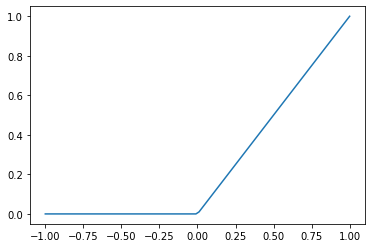

In [4]:
def area_cost(x:Tensor) -> Tensor:
    return F.relu(x)

x = torch.linspace(-1, 1)
plt.plot(x, area_cost(x))

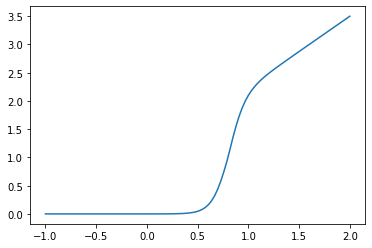

In [5]:
def area_coef(x:Tensor, targ:float) -> Tensor:
    return (2*torch.sigmoid(10*(x-targ)/targ)) + F.relu(x-targ)/targ

x = torch.linspace(-1, 2)
plt.plot(x, area_coef(x, 0.8))

In [ ]:
from typing import *

class DetectorLoss(nn.Module):
    def __init__(
        self,
        *,
        target_budget: float,
        budget_smoothing: float = 10,
        cost_coef: Optional[Union[Tensor, float]] = None,
        debug: bool = False,
    ):
        super().__init__()
        self.target_budget, self.budget_smoothing, self.cost_coef, self.debug = target_budget, budget_smoothing, cost_coef, debug
        self.sub_losses: Dict[str, Tensor] = {}  # Store subcomponents in dict for telemetry
        
    def _get_budget_coef(self, cost: Tensor) -> Union[float, Tensor]:
        r"""Switch-on near target budget, plus linear increase above budget"""
        if self.target_budget == 0:
            return 0
        d = cost - self.target_budget
        return (2 * torch.sigmoid(self.budget_smoothing * d / self.target_budget)) + (F.relu(d) / self.target_budget)

    def _compute_cost_coef(self, cost: Tensor, inference: Tensor) -> None:
        self.cost_coef = inference.detach().clone() / cost.detach().clone()
        print(f"Automatically setting cost coefficient to {self.cost_coef}")

    def forward(self, pred_x0: Tensor, pred_weight: Tensor, volume: Volume) -> Tensor:
        self.sub_losses = {}
        true_x0 = volume.get_rad_cube()
        inference = torch.mean((pred_x0 - true_x0).pow(2) / pred_weight)
        self.sub_losses["error"] = inference
        cost = volume.get_cost()
        if self.cost_coef is None:
            self._compute_cost_coef(cost, inference)
        self.sub_losses["cost"] = self._get_budget_coef(cost) * self.cost_coef * cost
        if self.debug:
            print(
                f'cost {cost}, cost coef {self.cost_coef}, budget coef {self._get_budget_coef(cost)}. error loss {self.sub_losses["error"]}, cost loss {self.sub_losses["cost"]}'
            )
        return self.sub_losses["error"] + self.sub_losses["cost"]

In [ ]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.5
    init_res = 1000
    n_panels = 4
    layers.append(PanelDetectorLayer(pos='above', lw=lwh[:2], z=1, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,1-(i*(2*size)/n_panels)], init_xy_span=[1.0,1.0],
                                                      area_cost_func=area_cost, device=DEVICE) for i in range(n_panels)]))
    for z in [0.8,0.7,0.6,0.5,0.4,0.3]:
        layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))
    layers.append(PanelDetectorLayer(pos='below', lw=lwh[:2], z=0.2, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,0.2-(i*(2*size)/n_panels)], init_xy_span=[1.0,1.0],
                                                      area_cost_func=area_cost, device=DEVICE) for i in range(n_panels)]))

    return nn.ModuleList(layers) 

In [ ]:
volume = Volume(get_layers())
volume

In [ ]:
volume.get_cost()

In [ ]:
wrapper = PanelVolumeWrapper(volume,
                             xy_pos_opt=partial(torch.optim.SGD, lr=5e4),
                             z_pos_opt=partial(torch.optim.SGD, lr=5e3),
                             xy_span_opt=partial(torch.optim.SGD, lr=5e3),
                             loss_func=DetectorLoss(target_budget=0.8, cost_coef=None, debug=True))  # Loss is precision + budget_coef*cost_coef*detector cost, balance coef as required or leave as None to automatically balance on first batch

In [ ]:
def arb_rad_length(*,z:float, lw:Tensor, size:float) -> float:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
    if z >= 0.4 and z <= 0.5: rad_length[5:,5:] = X0['lead']
    return rad_length

In [ ]:
passives = PassiveYielder([arb_rad_length])

In [ ]:
from tomopt.optimisation.callbacks.callback import Callback

class CostCoefAdapter(Callback):
    def __init__(self, mom:Union[float,Tensor]):
        self.mom = mom
        
    def on_epoch_begin(self) -> None:
        self.sum: Optional[Tensor] = None
        self.volume_cnt = 0
            
    def on_volume_end(self) -> None:
        if self.wrapper.fit_params.state == 'train' and self.wrapper.fit_params.pred is not None:
            v = self.wrapper.loss_func.sub_losses['error'].detach().clone()/self.wrapper.volume.get_cost().detach().clone()
            if self.sum is None:
                self.sum = v
            else:
                self.sum += v
            self.volume_cnt += 1
            
    def on_epoch_end(self) -> None:
        if self.wrapper.fit_params.state == 'train':
            avg = self.sum/self.volume_cnt
            if self.wrapper.loss_func.cost_coef is None: self.wrapper.loss_func.cost_coef = avg
            else:
                print('start coef', self.wrapper.loss_func.cost_coef, 'avg', avg)
                self.wrapper.loss_func.cost_coef.lerp_(avg, self.mom)
                print('end coef', self.wrapper.loss_func.cost_coef)
                

In [ ]:
_ = wrapper.fit(n_epochs=10,
                passive_bs=1,
                n_mu_per_volume=1000,
                mu_bs=100,
                trn_passives=passives,
                val_passives=passives,
                cbs=[CostCoefAdapter(0.05),PanelMetricLogger()])

In [ ]:
for p in volume.parameters(): print(p)